<a href="https://colab.research.google.com/github/UITTrinhQuangTruong/CS114.K21/blob/master/DetectingSarcasm_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chuẩn bị thư viện và dữ liệu

Khai báo thư viện

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Đọc dữ liệu từ file tải về lưu trong GG Drive bằng thư viện pandas

In [ ]:
import pandas as pd
# Dung pandas de doc file json

data = pd.read_json("/content/drive/My Drive/kaggle/CS114.K21/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json", lines=True)
data.head()



,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


Xóa cột đường dẫn đến bài báo vì không cần thiết.

In [ ]:
del data['article_link']

Kiểm tra lại data


In [ ]:
data.head(10)

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0
5,advancing the world's women,0
6,the fascinating case for eating lab-grown meat,0
7,"this ceo will send your kids to school, if you...",0
8,top snake handler leaves sinking huckabee camp...,1
9,friday's morning email: inside trump's presser...,0


Biểu đồ thống kê số text là châm biếm và ngược lại

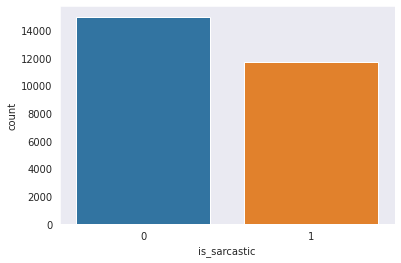

In [ ]:
sns.set_style("dark")
sns.countplot(data.is_sarcastic)

# Tiền xử lý

## StopWord là gì ?
Stopword là những từ trong câu khi mất đi không gây ảnh hưởng đến nghĩa của câu.
Ví dụ: the man is strong. -> Man is strong.
Những stopword này đã được thống kê trong corpus của thư viện nltk.


In [ ]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Xóa các stopword ra khỏi data:


In [ ]:
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

## Xóa tags html (nếu còn) trong headlines
Vd: h1, title

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [ ]:
'''soup = BeautifulSoup('<title>abc<h1>sd</title>', "html.parser")
soup.text'''

'abcsd'

##Xóa những phần thừa trong data

Xóa nội dung trong ngoặc vuông.
\\ trong thư viện re cho phép sử dụng kí tự sau nó không mang ý nghĩa đặc biệt. Ví dụ: \\[ ~ [. Vì trong re nếu dùng kí tự '[', ']' dùng để chỉ 1 tập các kí tự. 

In [ ]:
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

'''a = 'Dectect sarcasm [part 1]'
print(a)
a = remove_between_square_brackets(a)
a'''

Dectect sarcasm [part 1]


'Dectect sarcasm '

Xóa URL (nếu còn)

In [ ]:
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

'''a = 'http\\aab v'
remove_between_square_brackets(a)'''

' v'

Tổng hợp lại các hàm xử lý

In [ ]:
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

Áp dụng hàm denoise_text cho toàn bộ cột headlines

In [ ]:
data['headline']=data['headline'].apply(denoise_text)

#Tìm hiểu và biểu diễn dữ liệu

Biểu đồ phân bố số kí tự có trong một text




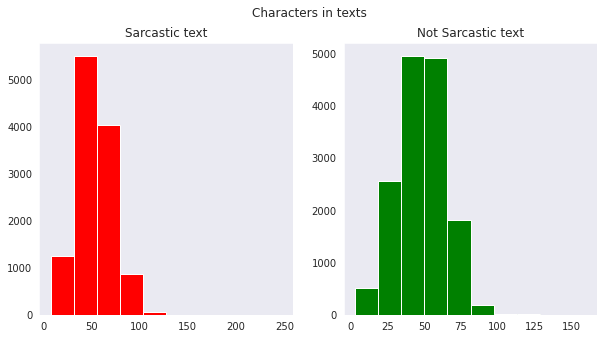

In [116]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=data[data['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=data[data['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Characters in texts')
plt.show()

Biểu đồ phân bố số từ có trong một text

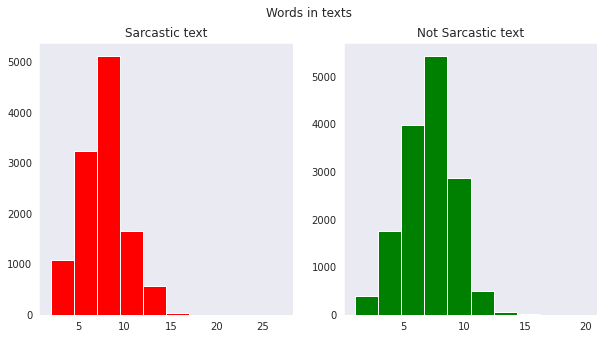

In [117]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=data[data['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=data[data['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Words in texts')
plt.show()

Độ dài trung bình của từ trong một text

Text(0.5, 0.98, 'Average word length in each text')

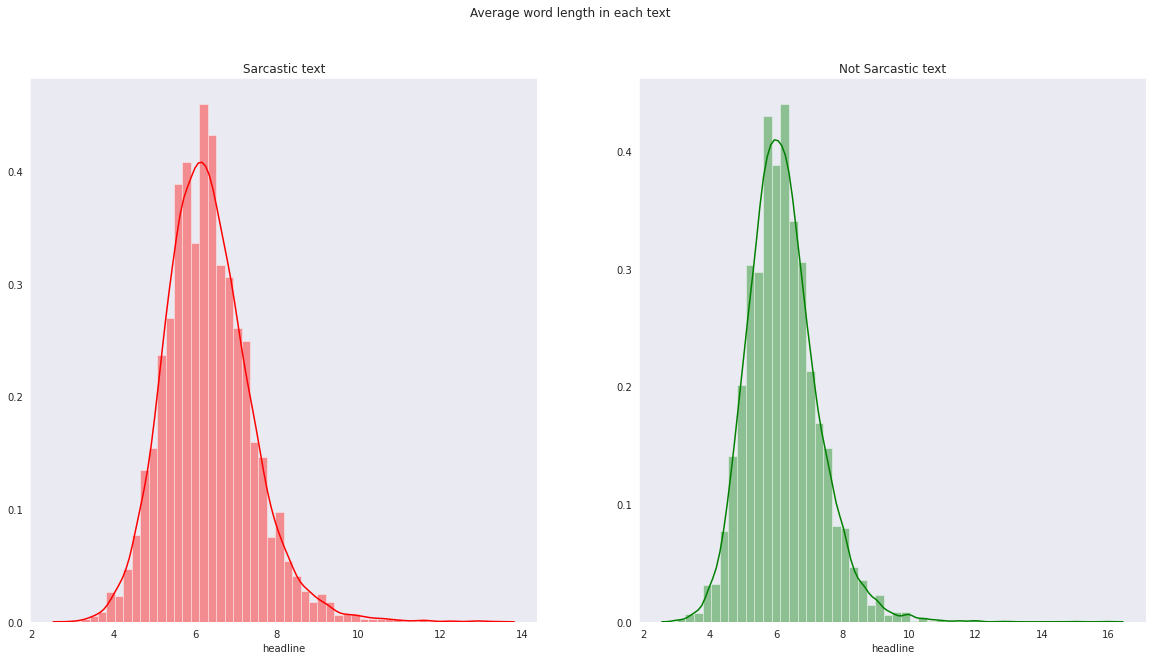

In [118]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=data[data['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic text')
word=data[data['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Average word length in each text')

Nhận xét :
- Các bài báo châm biếm thường có tiêu đề dài hơn so với các bài báo thường.
- Data train khá đồng đều giữa 2 trạng thái. 

#Giới thiệu Word2Vec

Là một model unsupervised learning được training từ large corpus. Gồm 2 model là skip-gram và Cbow. Cbow có thời gian train nhanh nhưng độ chính xác không cao bằng skip-gram và ngược lại.

##Chuẩn bị trước khi training Word2Vec model 

Chuyển đổi định dạng của text qua định dạng mà gensim có thể hiểu được

In [127]:
words = []
for i in data.headline.values:
    l = []
    for j in i.split():
        l.extend(i.split())
        break
    words.append(l)


'former'